##난 스케치를 할 테니 너는 채색을 하거라

개발 환경
<br/>데이터 정보


데이터 전처리
<br/>이미지 분할
<br/>Augmentation

모델 구성
<br/>U-Net Generator
<br/>Discriminator
<br/>Loss Function
<br/>Optimizer

모델 학습
<br/>결론
<br/>참고문헌

# 개발 환경

In [1]:
import os
import logging
import numpy as np
import pandas as pd

In [2]:
import cv2
from matplotlib import pyplot as plt

In [3]:
import tensorflow as tf
from tensorflow import data
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

In [4]:
from tensorflow.keras import layers, Input, Model
from tensorflow.keras import losses
from tensorflow.keras import optimizers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
pip freeze > '/content/drive/MyDrive/lms/library_version.txt'

In [ ]:
library_name = ['pandas=', 'numpy=', 'matplotlib=', 'keras=', 'tensorflow=', 'matplotlib=', 'opencv-python=']
library_version = []
f = open('/content/drive/MyDrive/lms/library_version.txt', 'r')
line = f.readline()
while True:
    line = f.readline()
    if not line:
      break
    for i in library_name:
      if i in line:
        library_version.append(line)
        library_version.append('    ')

f.close()

import sys
print(sys.version)
print()

for i in range(0, len(library_version) - 1, 6):
  print(str(library_version[i : i+6]).replace("[","").replace("]","").replace("'","").replace("\\n","").replace(",",""), end='') 
  if i % 6 == 0:
    print()

for i in range(len(library_version) - 1):
  if (i-1) % 6 == 0 and i == len(library_version) - 6:
    print(str(library_version[-1]).replace("[","").replace("]","").replace("'","").replace("\\n","").replace(",",""), end='')

3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]

keras==2.8.0      matplotlib==3.2.2      matplotlib==3.2.2     
numpy==1.21.6      opencv-python==4.1.2.30      pandas==1.3.5     
sklearn-pandas==1.8.0      tensorflow==2.8.2+zzzcolab20220527125636     


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Google Colab에서 할당된 GPU를 확인한다.
<br/>고용량 메모리 VM에 액세스한다.

#데이터 정보

[Cityscapes](https://www.cityscapes-dataset.com/)

Cityscapes 데이터셋은 32x32 픽셀의 컬러 이미지 5000장으로 구성된다.
<br/>인식한 이미지에 있는 객체를 픽셀로 분류하여 다각형으로 형태를 나타낸다.
<br/>픽셀의 크기에 따라 데이터셋이 Fine annotations과 Coarse annotations으로 분류된다.
<br/>미세한 점으로 각기 다른 색깔을 입혀 30개의 클래스로 분류하는 Fine annotations 데이터셋을 사용한다.

메타 데이터는 스테레오 비디오, GPS 데이터, 차량 주행거리의 에고모션 데이터, 차량 센서의 기온 데이터로 구성된다.
<br/>스테레오 카메라로 독일 50개 도시에서 수개월(봄, 여름, 가을) 동안 날씨가 괜찮은 날의 낮 시간에 비디오를 촬영했다.
<br/>비디오 30 프레임에서 20번째마다 이미지를 추출했다.

이미지는 클래스 30개로 분류한다.
<br/>객체가 속한 영역이 여러 개일 경우에 그 영역이 모두 포함된 전경을 클래스로 분류한다.
<br/>예를 들면 투명한 차 유리에 비친 구역에 사람(person) 혹은 집(building)이 있을 경우 그 구역을 차(car)라는 클래스로 분류한다.

flat &nbsp;&nbsp;|&nbsp;&nbsp;&nbsp;road · sidewalk · parking · rail track
<br/>human &nbsp;&nbsp;|&nbsp;&nbsp;&nbsp;person · rider
<br/>vehicle &nbsp;&nbsp;|&nbsp;&nbsp;&nbsp;car · truck · bus · on rails · motorcycle · bicycle · caravan · trailer
<br/>construction &nbsp;&nbsp;|&nbsp;&nbsp;&nbsp;building · wall · fence · guard rail · bridge · tunnel
<br/>object &nbsp;&nbsp;|&nbsp;&nbsp;&nbsp;pole · pole group · traffic sign · traffic light
<br/>nature &nbsp;&nbsp;|&nbsp;&nbsp;&nbsp;vegetation · terrain
<br/>sky &nbsp;&nbsp;|&nbsp;&nbsp;&nbsp;sky
<br/>void &nbsp;&nbsp;|&nbsp;&nbsp;&nbsp;ground · dynamic · static

In [8]:
train_path = '/content/drive/MyDrive/lms/conditional_generation/cityscapes/train/'
validation_path = '/content/drive/MyDrive/lms/conditional_generation/cityscapes/val/'

print("train data : ", len(os.listdir(train_path)))
print("validation data : ", len(os.listdir(validation_path)))

train data :  1000
validation data :  5


In [9]:
img_path = '/content/drive/MyDrive/lms/conditional_generation/cityscapes/train/1.jpg'
img_orig = cv2.imread(img_path) 

img_orig.shape

(256, 512, 3)

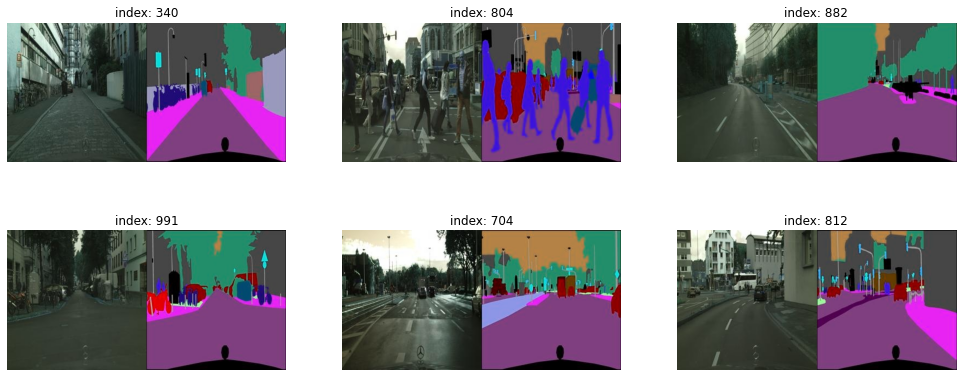

In [10]:
plt.figure(figsize=(17, 7))

for i in range(6):
    plt.subplot(2, 3, i+1)
    random_index = np.random.randint(1000)
    f = train_path + os.listdir(train_path)[random_index]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.imshow(img)
    plt.title(f'index: {random_index}')
    plt.axis('off')
plt.show()

#데이터 전처리

##이미지 분할

In [11]:
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

In [12]:
def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

In [13]:
def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

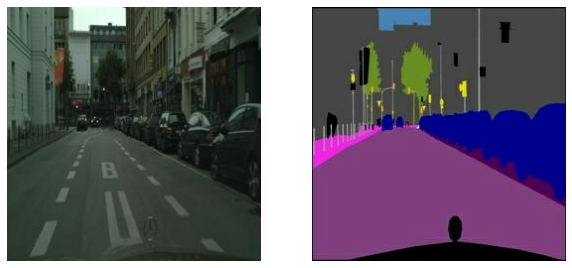

In [14]:
f = train_path + os.listdir(train_path)[1]
sketch, colored = load_img(f)

image_list = []
image_list.append(denormalize(sketch))
image_list.append(denormalize(colored))

plt.figure(figsize=(10, 7))

for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.imshow(image_list[i])
    plt.axis('off')
plt.show()

모델 학습에 사용할 데이터를 (256, 256, 3) 크기의 2개 이미지로 분할하여 사용한다.

##Augmentation

In [15]:
@tf.function() 
def apply_augmentation(sketch, colored):
    
    stacked = tf.concat([sketch, colored], axis=-1)
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])

    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)

    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)

    return out[...,:3], out[...,3:]

apply_augmentation 함수는 스케치 및 채색된 2개 이미지를 입력으로 받아 여러 가지 연산을 두 이미지에 동일하게 적용한다.
<br/>tensorflow 연산 속도를 높이기 위해 @tf.function()을 사용한다.
<br/>sketch, colored 이미지를 채널 축으로 연결한다. 3채널인 경우 6채널로 변환한다.
<br/>50%의 확률로 Refection padding 또는 constant padding 적용한다.
<br/>무작위로 crop한다.
<br/>50% 확률로 좌우상하 반전하고 회전시킨다.

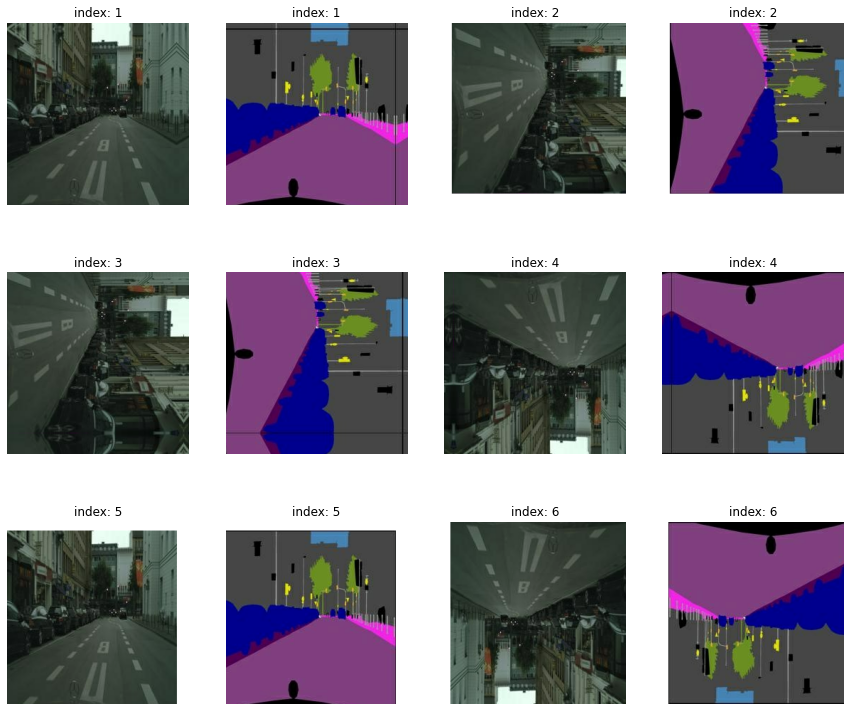

In [16]:
plt.figure(figsize=(15,13))
img_n = 1

for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"index: {img_n}"); plt.axis('off')
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"index: {img_n}"); plt.axis('off')
    img_n += 1
plt.show()

In [17]:
def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return colored, sketch

sketch와 colored 순서가 다르다.

In [18]:
train_images = data.Dataset.list_files(train_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

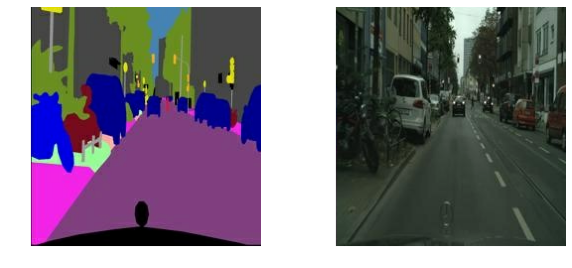

In [19]:
plt.figure(figsize=(10, 7))

image_list = []
image_list.append(sketch)
image_list.append(colored)

for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.imshow(image_list[i][0].astype(np.uint8))
    plt.axis('off')
plt.show()

#모델 구성

Pix2Pix는 이미지를 입력으로 하여 원하는 다른 형태의 이미지로 변환시킬 수 있는 GAN 모델이다.
<br/>Conditional Adversarial Networks로 Image-to-Image Translation을 수행한다.

##U-Net Generator

In [20]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

Encoder에 사용할 기본 블록을 구성한다.
<br/>Convolution, BatchNormalization, LeakyReLU의 3개 레이어로 구성된 기본적인 블록을 아래와 같이 하나의 레이어로 만든다.
<br/>init에서 n_filters, use_bn를 설정하여 사용할 필터의 개수와 BatchNorm 사용 여부를 결정한다.
<br/>필터의 크기(4)와 stride(2) 그리고 LeakyReLU 활성화의 slope coefficient(0.2)는 모든 곳에서 고정되어 사용하므로 각각의 값을 지정한다.

In [21]:
class DecodeBlock(layers.Layer):
    def __init__(self, n_filters, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

Decoder에 사용할 기본 블록을 구성한다.
<br/>Convolution, BatchNormalization, ReLU의 3개 레이어로 구성된 기본적인 블록을 아래와 같이 하나의 레이어로 만든다.
<br/>init에서 n_filters, dropout=True를 설정한다.
<br/>필터의 크기(4)와 stride(2) 그리고 Dropout(0.5)는 모든 곳에서 고정되어 사용하므로 각각의 값을 지정한다.

In [22]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]

        
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat]) 
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

Encoder와 Decoder간에 skip connection이 있는 U-Net Generator를 정의한다.
<br/>init에서 Encoder 및 Decoder에서 사용할 모든 블록들을 정의한다.
<br/>call 내부에서 차례대로 사용되어 Encoder 및 Decoder 내부 연산을 수행하며 forward propagation을 한다.
<br/>Encoder와 Decoder 사이의 skip connection을 위해 features 라는 리스트를 만들고 Encoder 내에서 사용된 각 블록들의 출력을 차례대로 담는다.
<br/>features 리스트에 있는 각각의 출력들이 Decoder 블록 연산 후 함께 연결되어 다음 블록의 입력으로 사용된다.

In [23]:
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 encode_block (EncodeBlock)     (None, 128, 128, 64  3072        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 encode_block_1 (EncodeBlock)   (None, 64, 64, 128)  131584      ['encode_block[0][0]']           
                                                                                              

##Discriminator

In [24]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
      
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x

init에서 필터의 수(n_filters), 필터가 순회하는 간격(stride), 출력 feature map의 크기를 조절하는 패딩(custom_pad),
<br/>배치 정규화의 사용 여부(use_bn), 활성화 함수 사용 여부(act)가 설정 가능하다.

In [25]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        filters = [64,128,256,512,1]

        self.blocks = [layers.Concatenate()]
        for i, f in enumerate(filters):
          self.blocks.append(DiscBlock(n_filters = f,
                                       stride = 2 if i < 3 else 1,
                                       custom_pad = False if i < 3 else True,
                                       use_bn = False if i == 0 and i == 4 else True,
                                       act = True if i<4 else False))   
        self.sigmoid = layers.Activation("sigmoid")
   
    def call(self, x, y):
        for block in self.blocks:
          if self.blocks[0] == block:
            x = block([x, y])
          else:
            x = block(x)
        return self.sigmoid(x)

    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

Pix2Pix의 Discriminator는 70x70 PatchGAN을 사용하기 때문에 최종 출력을 (30,30) 크기로 맞춘다.
<br/>첫 번째 블록은 단순한 연결(concat)을 수행하며 Discriminator의 최종 출력은 sigmoid 활성화를 사용한다.

In [26]:
Discriminator().get_summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_7 (Concatenate)    (None, 256, 256, 6)  0           ['input_2[0][0]',                
                                                                  'input_3[0][0]']          

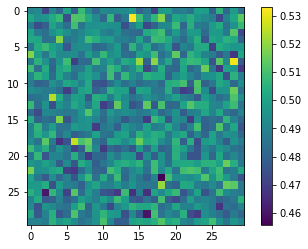

In [27]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()
plt.show()

임의의 (256,256,3) 크기의 입력에 따라 출력되는 (30,30)을 시각화한다.

##Loss Function

In [ ]:
bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

In [ ]:
def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

Generator의 손실 함수 get_gene_loss는 실제 이미지를 뜻하는 "1"과 비교하기 위해 tf.ones_like를 사용한다.
<br/> L1 손실을 계산하기 위해 생성한 가짜 이미지(fake_output)와 실제 이미지(real_output) 사이의 MAE(Mean Absolute Error)를 계산한다.

In [ ]:
def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

Discriminator의 손실 함수 get_disc_loss는 실제 이미지를 구분하기 위해
<br/>real_disc는 "1"로 채워진 벡터와 비교하고, fake_disc는 "0"으로 채워진 벡터와 비교한다.

##Optimizer

In [ ]:
gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

Adam Optimizer를 사용한다.

In [ ]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        
        fake_colored = generator(sketch, training=True)

        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)

        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== 

        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

GeneratorGAN 및 DiscriminatorGAN 모델 클래스를 이용한다.
<br/>입력으로 사용되는 노이즈를 100차원으로 설정했으며 하나의 배치 크기 데이터로 모델을 업데이트하는 함수를 정의한다.

fake_colored는 Generator의 예측이다.
<br/>fake_discdhk real_disc는 Discriminator의 예측이다.
<br/>gene_total_loss는 Generator 손실에 L1을 반영하여 계산한다.
<br/>disc_loss는 Discrminator 손실을 계산한다.
<br/>

#모델 학습

In [ ]:
EPOCHS = 1000

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)

        if (epoch == 1 or epoch % 100 == 0) and (i == 0 or (i + 1) == 250):
            print(f"EPOCH[{epoch}] - STEP[{i + 1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")
        

EPOCH[1] - STEP[1]                     
Generator_loss:0.7964                     
L1_loss:0.6063                     
Discriminator_loss:1.5971

EPOCH[1] - STEP[250]                     
Generator_loss:0.7134                     
L1_loss:0.2180                     
Discriminator_loss:1.4641

EPOCH[100] - STEP[1]                     
Generator_loss:0.6931                     
L1_loss:0.1436                     
Discriminator_loss:1.3863

EPOCH[100] - STEP[250]                     
Generator_loss:0.6931                     
L1_loss:0.1305                     
Discriminator_loss:1.3863

EPOCH[200] - STEP[1]                     
Generator_loss:0.6931                     
L1_loss:0.1411                     
Discriminator_loss:1.3863

EPOCH[200] - STEP[250]                     
Generator_loss:0.6931                     
L1_loss:0.1461                     
Discriminator_loss:1.3863

EPOCH[300] - STEP[1]                     
Generator_loss:0.6931                     
L1_loss:0.1179           

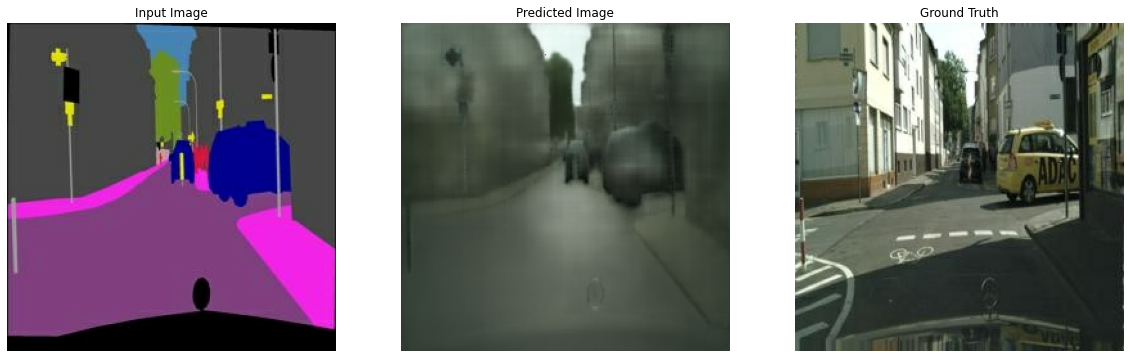

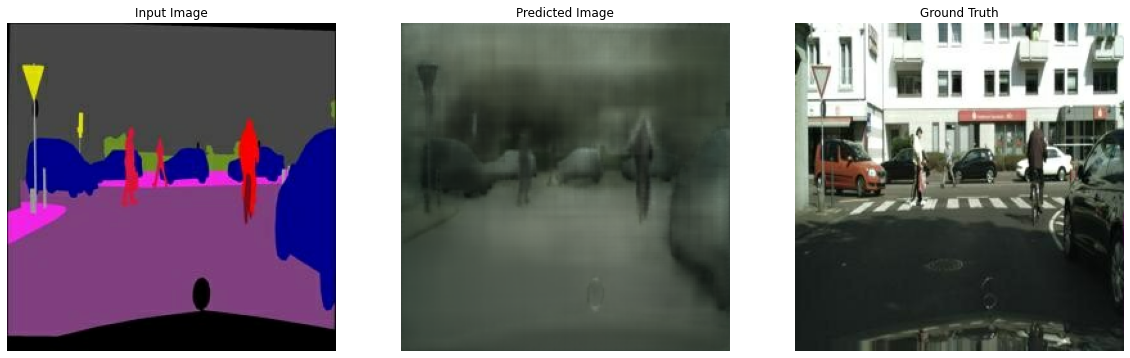

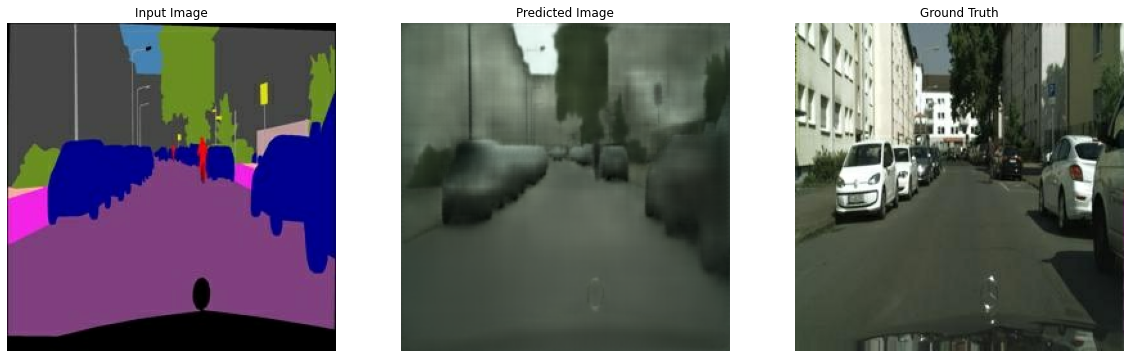

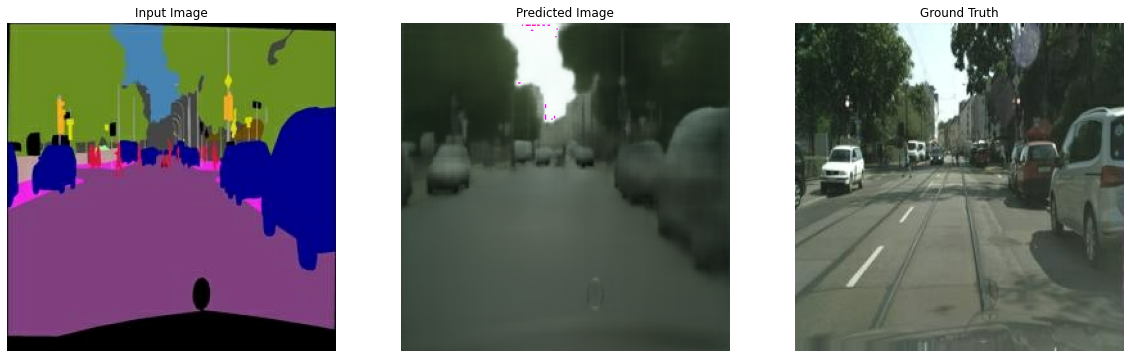

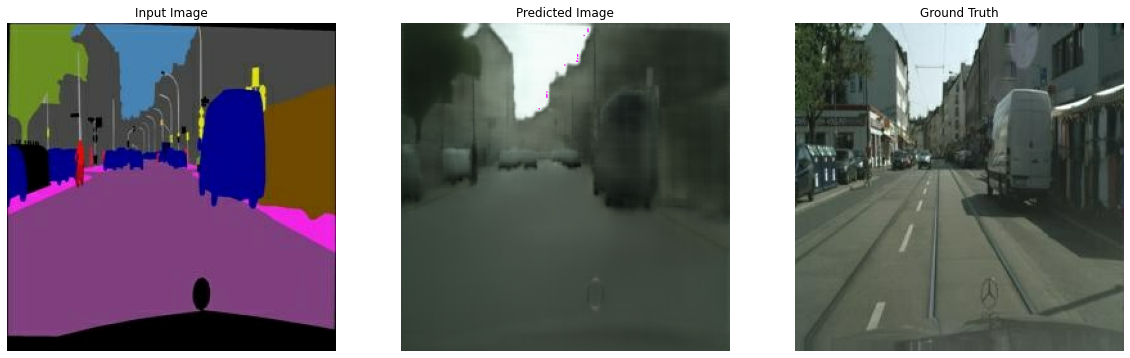

In [ ]:
for test_ind in range(len(os.listdir(validation_path))):
    
    f = validation_path + os.listdir(validation_path)[test_ind]
    colored, sketch = load_img(f)

    pred = generator(tf.expand_dims(sketch, 0))
    pred = denormalize(pred)

    image_list = []
    image_list.append(denormalize(sketch))
    image_list.append(pred[0])
    image_list.append(denormalize(colored))

    plt.figure(figsize=(20,10))

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.imshow(image_list[i])
        if i == 0:
          plt.title('Input Image')
        elif i == 1:
          plt.title('Predicted Image')
        elif i == 2:
          plt.title('Ground Truth')
        plt.axis('off')
    plt.show()

#결론

모델의 학습을 통해 출력된 이미지가 실제 이미지와 얼마나 유사한지 직접 눈으로 판별하기는 쉽지 않다.
<br/>따라서 Ground Truth와 Predicted Image의 유사도를 정량적으로 평가하는 방식을 사용하기도 한다.

이번에 Generator와 Discriminator의 손실 함수라는 하나의 지표를 측정하는 것으로 간단히 마무리했는데
<br/>다음에 GAN 모델의 평가방식을 공부한다면 여러 지표들을 추가하여 모델의 성능을 객관적으로 측정하고 싶다.


GAN 성능 측정 지표

Perceptual 기반의 평가 기법 : IS, FID, LPIPS
<br/><br/>IS(Inception Score)
<br/>FID 이전 많이 사용되던 Evaluation Metric이다. 
<br/>고품질의 이미지를 생성할수록, 하나의 클래스에만 속할 확률이 높아 엔트로피가 낮게 측정된다.
<br/>Diverse한 이미지를 생성한다면 엔트로피가 높게 측정된다.

<br/>FID(Frechet Inception Distance)
<br/>분류 모델에 따라 실제 이미지와 생성 이미지에서 특징량을 추출한다.
<br/>그들이 정규 분포를 따른다고 가정하고 그 분포 사이의 거리를 측정한다.
<br/>FID가 낮게 나온 생성된 이미지는 실제 이미지와 확률 분포적으로 유사하다고 본다.

<br/>LPIPS(Learned Perceptual Image Patch Similarity)
<br/>높은 LPIPS는 두 이미지가 Perceptually Similar하다고 본다.

<br/>픽셀 기반의 평가 기법 : PSNR, SSIM, MS-SSIM

<br/>PSNR(Peak Signal-to-Noise Ratio)
<br/>최대 신호 대 잡음비를 측정하여 영상 화질 손싱정보에 대해 평가한다.

<br/>SSIM(Structural Similarity Index)
<br/>밝기, 명암, 구조를 조합해 두 영상의 유사도를 평가한다.

<br/>MS-SSIM(Multi-Scale Structural Similarity Index)
<br/>다양한 배율에 대한 SSIM을 평가한다.
<br/>이미지의 유사도를 측정하며 학습한 GAN이 mode collapse하고 있는지 파악한다.

#참고문헌

**LMS**
<br/>[shsy0404g](https://github.com/SSinyu)

<br/>**논문**
<br/>[조병호, 박인규, 홍성은, 다중 스케일 얼굴 영역 딕셔너리의 적대적 증류를 이용한 얼굴 초해상화, 한국방송∙미디어공학회, 방송공학회논문지 vol.26 no.5, 2021, p.615](https://www.kci.go.kr/kciportal/ci/sereArticleSearch/ciSereArtiView.kci?sereArticleSearchBean.artiId=ART002761290)

<br/>**공식 사이트**
<br/>[Pix2Pix](https://www.tensorflow.org/tutorials/generative/pix2pix?hl=ko)

<br/>**웹사이트**
<br/>[GAN의 발전의 역사( 응용 편 )](https://doooob.tistory.com/174)
<br/>[DL GAN을 평가하는 방법 - IS, FID, LPIPS](https://jjuon.tistory.com/33)
<br/>[GAN의 평가와 편향](https://velog.io/@tobigs-gm1/evaluationandbias)
[딥모닝 1주차. PR12-001~006](https://zzsza.github.io/data/2018/11/11/deepmorning-week1/)